# Part I, Build Model

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

# save models to pickle
import pickle

In [6]:
path = 'kaggle_data/'
toxic_data = pd.read_csv(path + 'train.csv')
print('Number of rows and columns in the toxic data set:', toxic_data.shape)

Number of rows and columns in the toxic data set: (159571, 8)


In [7]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
# split toxic_data into train and test
train = toxic_data[:int(len(toxic_data)*0.7)]
test = toxic_data[int(len(toxic_data)*0.7):]

### Visualize variables

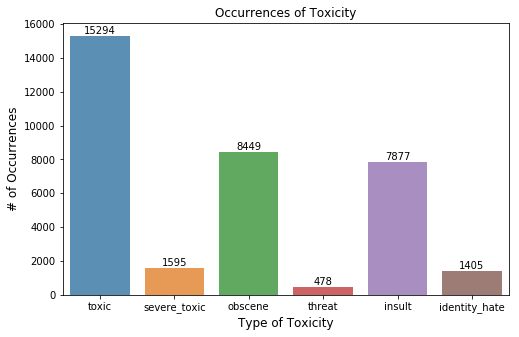

In [9]:
x = toxic_data.iloc[:, 2:].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Occurrences of Toxicity')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type of Toxicity', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

### Vectorizers

In [10]:
all_text = toxic_data['comment_text']

In [11]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)

train_word_features = word_vectorizer.transform(train['comment_text'])
test_word_features = word_vectorizer.transform(test['comment_text'])

In [12]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)

char_vectorizer.fit(all_text)

train_char_features = char_vectorizer.transform(train['comment_text'])
test_char_features = char_vectorizer.transform(test['comment_text'])

In [13]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

### Train & Score Models

In [14]:
models = {}
scores = []

for col in target_columns:
    train_target = train[col]
    classifier = LogisticRegression(C = 20, class_weight = 'balanced')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for {} is {}'.format(col, cv_score))

    classifier.fit(train_features, train_target)
    print('Building model for column: {}'.format(col))
    models[col] = classifier
    
print('Total CV score is {}'.format(np.mean(scores)))

CV score for toxic is 0.9684850869887941
Building model for column: toxic
CV score for severe_toxic is 0.9765443515018566
Building model for column: severe_toxic
CV score for obscene is 0.9839645135877095
Building model for column: obscene
CV score for threat is 0.9822256110385611
Building model for column: threat
CV score for insult is 0.9710518671231293
Building model for column: insult
CV score for identity_hate is 0.9698118609652554
Building model for column: identity_hate
Total CV score is 0.9753472152008844


In [15]:
for col in target_columns:
    filename = 'model_{}.sav'.format(col)
    pickle.dump(model[col], open(filename, 'wb'))

NameError: name 'model' is not defined

In [ ]:
filename = 'model_toxic.sav'
loaded_model = pickle.load(open(filename, 'rb'))

# Part 2, Predict Tweet Toxicity

In [87]:
df = pd.read_csv("twitter_data/scraped_tweets", encoding = "ISO-8859-1",
                 usecols = ['date', 'fullname', 'id', 'likes', 'replies', 
                            'retweets', 'text', 'url', 'user', 'month'])

In [88]:
df.head()

date        fullname                  id  likes  replies  \
0  2016-01-01 23:59:59   John Sherlock  683075226960187392      1        0   
1  2016-01-01 23:59:58      B. Justice  683075224036847616      0        0   
2  2016-01-01 23:47:22        ABC News  683072049661620225    344      166   
3  2016-01-01 18:04:12    Philip Lewis  682985689441525766    224        2   
4  2016-01-01 23:59:56  Breitbart News  683075211755962368     71       59   

   retweets                                               text  \
0         0  "America is great. Trump is disgusting." #Rose...   
1         0  @realDonaldTrump @marie7777777777 Are Trump's ...   
2       704  Terror group Al-Shabaab releases recruitment v...   
3       355  "Your President, Donald Trump." https://twitte...   
4       161  Marco Rubio Campaign Donor Behind Anti-Trump S...   

                                        url           user       month  
0  /JohnCSherlock/status/683075226960187392  JohnCSherlock  2016-01-01  
1    /zefirotorna/status/683075224036847616    zefirotorna  2016-01-01  
2            /ABC/status/683072049661620225            ABC  2016-01-01  
3    /Phil_Lewis_/status/682985689441525766    Phil_Lewis_  2016-01-01  
4  /BreitbartNews/status/683075211755962368  BreitbartNews  2016-01-01

In [94]:
len(df)

582

### Vectorize tweets and predict toxicity with model

In [98]:
tweet_word_features = word_vectorizer.transform(df['text'])
tweet_char_features = char_vectorizer.transform(df['text'])
tweet_features = hstack([tweet_word_features, tweet_char_features])

In [100]:
for col in target_columns:
    df[col] = models[col].predict_proba(tweet_features)[:, 1]

In [16]:
df['classification'] = df[target_columns].idxmax(axis=1)

NameError: name 'df' is not defined

In [17]:
df.head(10)

NameError: name 'df' is not defined

In [18]:
# export df
df.to_csv("classified_tweets")

### Visualizations

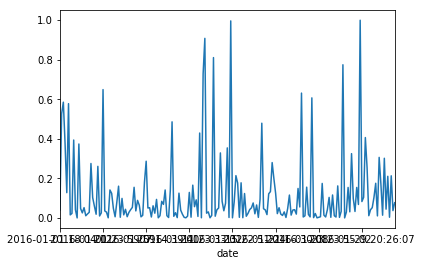

In [32]:
# visualize obscenity
df.groupby('date')['obscene'].mean().plot()

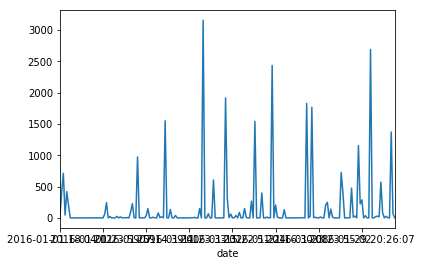

In [37]:
df['likes'] = df['likes'].astype(float)

# normalizing identity hate by tweet popularity
df['popular_obscene'] = df['obscene']*df['likes']
df.groupby('date')['popular_obscene'].mean().plot()

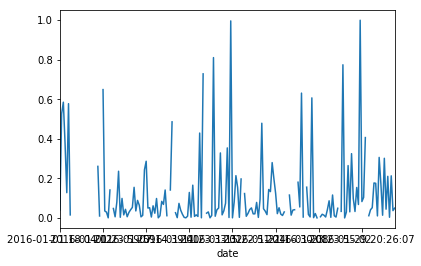

In [38]:
# normalizing identity hate by number of popular tweets
(df.groupby('date')['popular_obscene'].sum() / df.groupby('date')['likes'].sum()).plot()

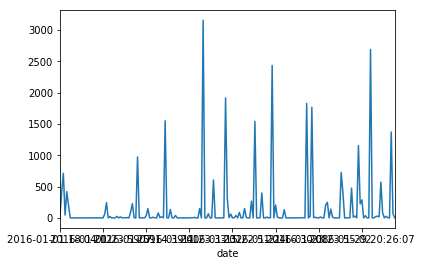

In [39]:
# normalizing popular tweets by number of popular tweets
(df.groupby('date')['popular_obscene'].sum() / df.groupby('date')['likes'].count()).plot()